In [1]:
cd ..


C:\Users\Nghia\PycharmProjects\ECML\Refactor


In [2]:
from pprint import pprint

import numpy as np
import tensorflow as tf
import time
from collections import Counter

from load_datasets import usps
from metrics import metrics
from models.AE1SVM import AEOneClassSVM

c:\users\nghia\anaconda2\envs\tf36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.set_random_seed(2018)

x_train, y_train, x_test, y_test = usps(random_state=3, anomaly_num=7)

counter = Counter(y_train)
print('Anomalies ratio:', 100*counter[-1]/(counter[1]+counter[-1]), '%')

Anomalies ratio: 5.0 %


In [4]:
autoencoder_layers = [256, 128]
batch_size = 16

data_input = tf.placeholder(tf.float32, shape=[None, 256])

In [5]:
ae1svm = AEOneClassSVM(data_input, batch_size, 'test', autoencoder_layers[:1], 0.25, 1e3, 3.0, 500,
                       autoencoder_activation='sigmoid', full_op=tf.train.AdamOptimizer(1e-2),
                       svm_op=tf.train.AdamOptimizer(1e-2))

In [6]:
import matplotlib
import matplotlib.pyplot as plt

normal = x_test[np.where(y_test == 1)]
anomalies = x_test[np.where(y_test == -1)]

Combined train
SVM train
...............Train time: 0.9014050960540771
Test time: 0.018549442291259766
{'AUPRC': 0.625,
 'AUROC': 0.9842105263157895,
 'Confusion matrix': array([[ 25,   0],
       [ 15, 460]], dtype=int64),
 'F1': 0.7692307692307693,
 'Precision': 0.625,
 'Recall': 1.0}


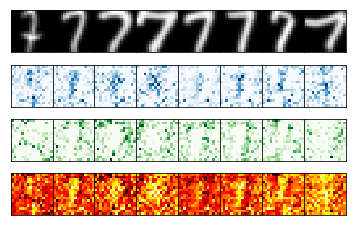

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Autoencoder-OneclassSVM
    t0 = time.time()
    ae1svm.fit(sess, x_train, epochs_1=0, epochs_2=15)
    print('Train time:', time.time() - t0)

    t0 = time.time()
    out_y = ae1svm.predict(sess, x_test)
    print('Test time:', time.time() - t0)
    pprint(metrics(y_test, out_y))
    
    gs = matplotlib.gridspec.GridSpec(4, 8)
    gs.update(wspace=0, hspace=0)
    for n in range(8):
        a = anomalies[n]
        g = sess.run(ae1svm.gradient, {data_input: [anomalies[n]]})
        g = np.reshape(g, (256, len(g)))

        splt = plt.subplot(gs[n])
        splt.imshow(np.reshape(anomalies[n], (16, 16)), cmap='gray')
        splt.set_xticks([])
        splt.set_yticks([])
        
        splt = plt.subplot(gs[n+8])
        splt.imshow(np.maximum(0, np.reshape(g, (16, 16))), cmap='Blues')
        splt.set_xticks([])
        splt.set_yticks([])

        splt = plt.subplot(gs[n+16])
        splt.imshow(np.maximum(0, -np.reshape(g, (16, 16))), cmap='Greens')
        splt.set_xticks([])
        splt.set_yticks([])
        
        splt = plt.subplot(gs[n+24])
        splt.imshow(np.reshape(g, (16, 16)), cmap='hot')
        splt.set_xticks([])
        splt.set_yticks([])  

plt.savefig('usps_gradient.eps', bbox_inches='tight')